# MicroJax

This is micro dev blog on how do build micro Jax / mlx like transformation engine,
bcs I dont find anything easy on internet. just like karpathy senpais micrograd is simple version of pytorch, microjax is simple scalar valued version on jax,

waraning: this is made for understanding so absulte correctness is not respcted

way back google was tensorflow pilled, google has custom chip TPU and XLA really smart linear algebra compiler to make it go burr, but tensorflow was awefull and dynamic nature of torch wasnt that great, Jax was exprimentail project from google that was heavly used for physics simlution, hpc. and ai ofc, but story jax gose back, back to autograd, somewhere in 2019 all autograd dev moved on working on jax

autograd had more noval goal, you need to calculate gradients (dertivative) , hassions (double derivate) for machine learning and physics sims, python is language of scientific computing lets makes python diffrentiable, but how can one make high level, Interpreted language like python diffrentiable,

by writing interpretor ofcouse,

## Base Interpretor
first we will start primitive, this are fundameation ops in jax land all all other oprator will be base on it, btw this is scalr only so its more easy

In [1]:
from __future__ import annotations

import math
from contextlib import contextmanager
from typing import Any, Callable

In [2]:
class OPS:
    ADD = "add"
    MUL = "mul"
    NEG = "neg"
    RECIP = "recip"
    EXP = "exp"
    SIN = "sin"
# ik i can make this enum, i choose not too\
print(OPS.ADD)

add


We will use only this for now, but later you can add more ops

Lets start with base interpretor, this is like abstract class, in jax this called Trace, Trace keep track and guider values (Tracers)

In [3]:
class Interpreter:
    def __init__(self, level: int = 0, *args, **kwargs):
        self.level = level

    def process_primitive(self, prim, boxes, params):
        "in this function, either you process primitives or you unbox and send to lower level interpreter"
        raise NotImplementedError

Now we will have multiplal interpreters for diffren AD so lets add most powerful data structer in exitace Stack,
this stack will keep track which interpretor are we using
ie what is context

In [4]:
STACK: list[Interpreter] = []


def push_interpreter(interpreter: Interpreter):
    STACK.append(interpreter)
    return STACK


def pop_interpreter() -> Interpreter:
    return STACK.pop()


@contextmanager
def interpreter_context(interpreter_type: Interpreter):
    stack_item = interpreter_type(level=len(STACK))
    push_interpreter(stack_item)
    try:
        yield stack_item
    finally:
        pop_interpreter()

Next up Box (called tracer in jax), 
When you pass values to function (like sin) this are boxed, <br>
this boxed values can keep track of primals for jvp, nodes for vjp or other things like shape,


In [5]:
class Box:
    _interpreter: Interpreter

    def aval(self):
        raise NotImplementedError

    def full_lower(self):
        return self

    def __add__(self, other):
        return add(self, other)

    def __radd__(self, other):
        return add(other, self)

    def __mul__(self, other):
        return mul(self, other)

    def __rmul__(self, other):
        return mul(other, self)

    def __neg__(self):
        return neg(self)

    def __sub__(self, other):
        return add(self, neg(other))

    def __rsub__(self, other):
        return add(other, neg(self))

    def __truediv__(self, other):
        return mul(self, recip(other))

    def __rtruediv__(self, other):
        return mul(other, recip(self))

    def __iadd__(self, other):
        return add(self, other)

    def __imul__(self, other):
        return mul(self, other)

    def __isub__(self, other):
        return add(self, neg(other))

    def __itruediv__(self, other):
        return mul(self, recip(other))

# dont worry about this undefined functions, we add them later

we are almost done with abstract classes 
just few helper

In [6]:
def find_top_interpreter(args):
    interpreters = []
    for item in args:
        if isinstance(item, Box):
            interpreters.append(item._interpreter)

    if interpreters:
        return max(interpreters, key=lambda x: x.level)

    # if no interpreters are found, return the default EvalInterpreter
    return STACK[0]


def full_raise(interpreter: Interpreter | Any, out) -> Box | JVPBox:
    """
    if interpreter need values boxed
    if out is not boxed, box it (using interpreter.pure)
    ie. raise out to the box level
    """
    if not isinstance(out, Box):
        return interpreter.pure(out)
    return out


def full_lower(val):
    if isinstance(val, Box):
        return val.full_lower()
    return val


def bind(prim, *args, **params):
    interpreter = find_top_interpreter(args)
    # this will raise the boxes to the top level
    # eg converts primitive values to Boxes if interpreter is not the top level
    boxes = [full_raise(interpreter, arg) for arg in args]
    outs = interpreter.process_primitive(prim, boxes, params)
    return [out for out in outs]


def bind_single(prim, *args, **params):
    (out,) = bind(prim, *args, **params)
    return out

each boxed value will have interpretor assigned to it each inter pretor will have levels to them `find_top_interpreter` will find hight level interpretor amoung them all. 
`full_raise` will raise up value to till current interpretor level in stack.  `bind_single` is just small wrapper to handle tuple around bind. `bind` is function to primitive ops

### Primitives
This are building blocks, all other functions will build on top of this, 

In [7]:
def add(*args):
    return bind_single(OPS.ADD, *args)

def mul(*args):
    return bind_single(OPS.MUL, *args)

def neg(x):
    return bind_single(OPS.NEG, x)

def recip(x):
    return bind_single(OPS.RECIP, x)

def exp(x):
    return bind_single(OPS.EXP, x)

def sin(x):
    return bind_single(OPS.SIN, x)

# composite functions build on top of primitives
def cos(x):
    return sin(x + math.pi / 2)

def sigmoid(x):
    return 1 / (1 + exp(-x))

def tanh(x): 
    return 2 * sigmoid(2 * x) - 1

def silu(x):
    return x * sigmoid(x)

primitive are like mock function,  when you call `mul(Box1(3),Box1(2))` this will find interpertors for `box1`,`box2`, than will find will `interpretor`
 have highest level amoung them unbox this values and tell that interpretor to process those primitive,
for evey op type there is primitive op function.

### Eval Interpretor

Even it all this mocking at the end someone has to run `add` or `mul` function this will be dose by eval interprer we will fist define evaultion reule and then eval interpretor

In [8]:
class EvalRules:
    def __init__(self):
        self.rules = {
            OPS.ADD: self.add,
            OPS.MUL: self.mul,
            OPS.NEG: self.neg,
            OPS.RECIP: self.recip,
            OPS.EXP: self.exp,
            OPS.SIN: self.sin,
        }

    def __getitem__(self, op):
        return self.rules[op]

    def add(self, primals, *args):
        x, y = primals
        return [x + y]

    def mul(self, primals, *args):
        x, y = primals
        return [x * y]

    def neg(self, primals, *args):
        (x,) = primals
        return [-x]

    def recip(self, primals, *args):
        (x,) = primals
        return [1 / x]

    def exp(self, primals, *args):
        (x,) = primals
        return [math.exp(x)]

    def sin(self, primals, *args):
        (x,) = primals
        return [math.sin(x)]


class EvalInterpreter(Interpreter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rules = EvalRules()

    def pure(self, val):
        return val

    def process_primitive(self, prim, boxes, params):
        return self.rules[prim](boxes, *params)

Basic interpreter is `EvalInterpreter`, Now we run run basic program, since evalution are end of primitive we will push eval interpreter at bottom of stack,

In [9]:
push_interpreter(EvalInterpreter())

Now we can kick off basic program,

In [10]:
def func(x):
    return sin(x)*exp(x) + tanh(x)

x = 3.14

func(x)

1.033056645880499

## Forwardmode Autodiff (JVP)

TODO: explaintion of JVP

# Autograd: Jacobian-Vector Product (JVP) Calculation

This README explains the process of calculating the Jacobian-Vector Product (JVP) for a given function using autograd principles.

## Function Definition

Given:
- $x = [x_1, x_2]$
- $f(x) = \sin(x) \cdot x$

## Jacobian of Primitives

### 1. Sine function

The Jacobian of $\sin(x)$ is:

$$
J_{\sin}(x) = \begin{bmatrix}
\cos(x_1) & 0 \\
0 & \cos(x_2)
\end{bmatrix}
$$

### 2. Element-wise multiplication

The Jacobian of element-wise multiplication $a \cdot b$ is:

$$
J_{\text{mul}}(a, b) = \begin{bmatrix}
b & a \\
a & b
\end{bmatrix}
$$

## Chain Rule

For composed functions, we multiply the Jacobians of each operation in reverse order.

## JVP Definition

The Jacobian-Vector Product (JVP) is defined as the product of the Jacobian of a function and a vector:

$$
\text{JVP}(f, x, v) = J_f(x) \cdot v
$$

where $J_f(x)$ is the Jacobian of $f$ at $x$.

## Applying the Chain Rule

For our function $f(x) = \sin(x) \cdot x$, the Jacobian can be expressed as:

$$
J_f(x) = J_{\text{mul}}(\sin(x), x) \cdot J_{\sin}(x)
$$

## Calculating the JVP

Using the chain rule and the property $(AB)v = A(Bv)$ for matrices $A$, $B$, and vector $v$:

$$
\begin{aligned}
\text{JVP}(f, x, v) &= J_f(x) \cdot v \\
&= (J_{\text{mul}}(\sin(x), x) \cdot J_{\sin}(x)) \cdot v \\
&= J_{\text{mul}}(\sin(x), x) \cdot (J_{\sin}(x) \cdot v)
\end{aligned}
$$

### Step-by-step calculation:

1. Calculate $J_{\sin}(x) \cdot v$:

$$
\begin{bmatrix}
\cos(x_1) & 0 \\
0 & \cos(x_2)
\end{bmatrix} \cdot
\begin{bmatrix}
v_1 \\
v_2
\end{bmatrix} =
\begin{bmatrix}
\cos(x_1) \cdot v_1 \\
\cos(x_2) \cdot v_2
\end{bmatrix}
$$

2. Apply $J_{\text{mul}}(\sin(x), x)$:

$$
\begin{bmatrix}
x_1 & \sin(x_1) \\
\sin(x_2) & x_2
\end{bmatrix} \cdot
\begin{bmatrix}
\cos(x_1) \cdot v_1 \\
\cos(x_2) \cdot v_2
\end{bmatrix} =
\begin{bmatrix}
x_1 \cos(x_1) v_1 + \sin(x_1) \cos(x_2) v_2 \\
\sin(x_2) \cos(x_1) v_1 + x_2 \cos(x_2) v_2
\end{bmatrix}
$$

Therefore, the final JVP is:

$$
\text{JVP}(f, x, v) = \begin{bmatrix}
x_1 \cos(x_1) v_1 + \sin(x_1) \cos(x_2) v_2 \\
\sin(x_2) \cos(x_1) v_1 + x_2 \cos(x_2) v_2
\end{bmatrix}
$$

This JVP calculation demonstrates how autograd works by applying the chain rule to primitive operations and combining them to compute the derivative of more complex functions.


$$
\text{JVP} = 
\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}
\cdot
\begin{bmatrix} \exp(x_1) & 0 \\ 0 & \exp(x_2) \end{bmatrix}
\cdot
\begin{bmatrix} \cos(a_1) & 0 \\ 0 & \cos(a_2) \end{bmatrix}
\cdot
\begin{bmatrix} v_1 \\ v_2 \end{bmatrix}
$$

In [42]:
class JVPBox(Box):
    def __init__(self, interpretor: Interpreter, primal, tangent) -> None:
        super().__init__()
        self._interpreter = interpretor
        self.primal = primal
        self.tangent = tangent
    
    def __repr__(self):
        return f"JVPBox (primal={self.primal}, tangent={self.tangent})"


In [43]:
class JVPRules:
    def __init__(self):
        self.rules = {
            OPS.ADD: self.add,
            OPS.MUL: self.mul,
            OPS.NEG: self.neg,
            OPS.RECIP: self.recip,
            OPS.EXP: self.exp,
            OPS.SIN: self.sin,
        }

    # dont forget to return tuple(primals),tuple(tangents)
    def __getitem__(self, op):
        return self.rules[op]

    @staticmethod
    def add(primals, tangents):
        (x, y), (x_dot, y_dot) = primals, tangents
        return (x + y,), (x_dot + y_dot,)

    @staticmethod
    def mul(primals, tangents):
        (x, y), (x_dot, y_dot) = primals, tangents
        return (x * y,), (x_dot * y + x * y_dot,)

    @staticmethod
    def neg(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        return (-x,), (-x_dot,)

    @staticmethod
    def recip(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        y = 1 / x
        return (y,), (-y * y * x_dot,)

    @staticmethod
    def exp(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        y = exp(x)
        return (y,), (y * x_dot,)

    @staticmethod
    def sin(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        return (sin(x),), (cos(x) * x_dot,)


In [44]:
class JVPInterpreter(Interpreter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rules = JVPRules()

    def pure(self, val):
        return JVPBox(self, val, 0.0)

    def process_primitive(self, prim, boxes, params):
        primals = [box.primal for box in boxes]
        tangents = [box.tangent for box in boxes]
        op = self.rules[prim]
        primals_out, tangents_out = op(primals, tangents, **params)

        result = []
        for p, t in zip(primals_out, tangents_out):
            result.append(JVPBox(self, p, t))
        return result


In [45]:
def jvp_simple(func, primals, tangents):
    with interpreter_context(JVPInterpreter) as iptr:
        box_in = [JVPBox(iptr, x, t) for x, t in zip(primals, tangents)]
        out = func(*box_in)
        box_out = full_raise(iptr, out)
        primal_out, tangent_out = box_out.primal, box_out.tangent
    return primal_out, tangent_out

In [46]:

def deriv(function):
    def jvp_forward(input_value):
        _, gradient = jvp_simple(function, (input_value,), (1,))
        return gradient

    return jvp_forward



In [47]:
def func(x):
    return sin(x) + tanh(x)

x = 3.14

print(func(x))

print(deriv(func)(x))
print(deriv(deriv(func))(x))

0.9978528578623186
-0.9925331276862505
-0.01646802134092456


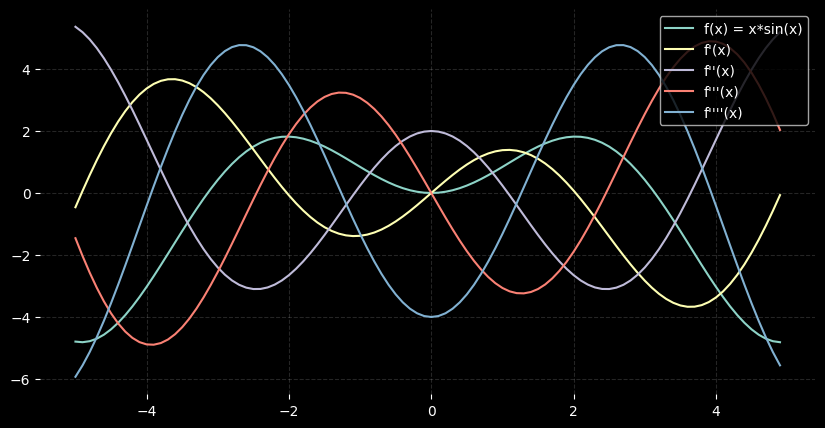

In [48]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(10,5))
plt.style.use("dark_background")

def forward(func, vec):
    return [func(x) for x in vec]


x = [i / 10 for i in range(-50, 50)]

def func(x):
    return x*sin(x)

primals = forward(func, x)

# first derivative
f_prime = forward(deriv(func), x)
f_prime2 = forward(deriv(deriv(func)), x)
f_prime3 = forward(deriv(deriv(deriv(func))), x)
f_prime4 = forward(deriv(deriv(deriv(deriv(func)))), x)

plt.plot(x, primals, label='f(x) = x*sin(x)')
plt.plot(x, f_prime, label="f'(x)")
plt.plot(x, f_prime2, label="f''(x)")
plt.plot(x, f_prime3, label="f'''(x)")
plt.plot(x, f_prime4, label="f''''(x)")

plt.grid(True, linestyle="--", alpha=0.15)
plt.box(False)
plt.legend(loc='upper right')
plt.show()


In [50]:
import torch
import torch.autograd.functional as F

def f(x):
    return torch.sin(x) * x

def manual_jvp(x, v):
    sin_x = torch.sin(x)
    cos_x = torch.cos(x)
    return x * cos_x * v + sin_x * v

def test_jvp():
    # Set random seed for reproducibility
    torch.manual_seed(0)

    # Create input tensor
    x = torch.rand(2, requires_grad=True)
    
    # Create random vector
    v = torch.rand(2)

    # Calculate manual JVP
    manual_result = manual_jvp(x, v)

    # Calculate JVP using PyTorch's autograd
    autograd_result = F.jvp(f, x, v)[1]

    # Print results
    print(f"Input x: {x}")
    print(f"Vector v: {v}")
    print(f"Manual JVP: {manual_result}")
    print(f"Autograd JVP: {autograd_result}")

    # Check if results are close
    assert torch.allclose(manual_result, autograd_result, atol=1e-6), "Manual and autograd results don't match!"
    print("Manual and autograd results match!")

if __name__ == "__main__":
    test_jvp()

Input x: tensor([0.4963, 0.7682], requires_grad=True)
Vector v: tensor([0.0885, 0.1320])
Manual JVP: tensor([0.0807, 0.1647], grad_fn=<AddBackward0>)
Autograd JVP: tensor([0.0807, 0.1647])
Manual and autograd results match!
